# Topog form stress using MOM025 DATA

Recent update 01 Oct 2017

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid


# Load Data

## All difference between dht and $\sum dz$ are equally added upto each partial cell.

In [3]:
g = 9.8

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')

pf=np.zeros([50,1080,1440])# store pbot*dz in each z-cell
mark=np.zeros([50,1080,1440]) 

for yy in range(217,218):
    kmt = dsx1.kmt.isel(yt_ocean=yy)    # "number of depth levels on t-grid"
    depth = dsx1.ht.isel(yt_ocean=yy)   # ht, depth
    pbot = dsx2.pbot_t.mean('time').isel(yt_ocean=yy)   # p_bot
    dz = dsx3.dzt.mean('time').isel(yt_ocean=yy)        # t-cell thickness
    rho = dsx3.rho.mean('time').isel(yt_ocean=yy)       # \rho in-situ    
    z=np.zeros(kmt.shape).astype(np.int64)              # define z initial
    z[:]=kmt[:].values-1                # layer number z[x]             
    for x in range(0,1440):
        if (z[x]>-1)&(z[x-1]>-1):      # x & x-1 are not continent landmasses  
            if z[x]-z[x-1]==0:
                dz1=depth[x-1]-depth[x]
                if dz1<0:
                    rhom=rho[z[x],x]
                    pf[z[x-1],yy,x-1]=pf[z[x-1],yy,x-1]+(10000*pbot[x]*(-dz1)-g*rhom*(dz1)**2/2) 
                elif (dz1)>0:
                    rhom=rho[z[x-1],x-1]
                    pf[z[x],yy,x]=pf[z[x],yy,x]-(10000*pbot[x-1]*(dz1)-g*rhom*(dz1)**2/2)
            else:
                if depth[x]-depth[x-1]>0:
                    dz1=depth[x]-depth[x-1]   # total depth difference
                    dzz = (depth[x]-depth[x-1]-np.sum(dz[z[x-1]:z[x]+1,x]) + dz[z[x-1],x-1])/(z[x]-z[x-1]+1)  # correction          
                    pa=10000*pbot[x]          # choose pbot pressure
                    zm=dz[z[x],x]+dzz             # dz of lowest layer
                    rhom=rho[z[x],x]          # density
                    pm = pa-zm*g*rhom/2       #pressure at middle of each partial cell
                    pf[z[x],yy,x-1]=pf[z[x],yy,x-1]+pm*zm
                    pa=pa-zm*g*rhom           #update press reference to upper partial cell
                    dz1=dz1-zm                    
                    for i in range(1,z[x]-z[x-1]):  #calculate from bottom partial cell in each layer             
                        zm=dz[z[x]-i,x]+dzz        
                        rhom=rho[z[x]-i,x]          #density
                        pm = pa-zm*g*rhom/2         #pressure at middle of each partial cell
                        pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                        mark[z[x]-i,yy,x-1]=1-mark[z[x]-i,yy,x-1]
                        pa=pa-zm*g*rhom             #update press reference to upper partial cell
                    zm=dz[z[x-1],x]-dz[z[x-1],x-1]+dzz
                    rhom=rho[z[x-1],x]                
                    pm = pa-zm*g*rhom/2
                    pf[z[x-1],yy,x-1]=pf[z[x-1],yy,x-1]+pm*zm 
                    mark[z[x-1],yy,x-1]=1-mark[z[x-1],yy,x-1]
                elif depth[x]-depth[x-1]<0:
                    dz1=depth[x-1]-depth[x]
                    pa=10000*pbot[x-1]
                    dzz = (depth[x-1]-depth[x]-np.sum(dz[z[x]:z[x-1]+1,x-1])+dz[z[x],x])/(z[x-1]-z[x]+1) 
                    zm=dz[z[x-1],x-1]+dzz
                    rhom=rho[z[x-1],x-1]
                    pm = pa-zm*g*rhom/2
                    pf[z[x-1],yy,x]=pf[z[x-1],yy,x]-pm*zm
                    pa=pa-zm*g*rhom 
                    dz1=dz1-zm
                    for i in range(1,z[x-1]-z[x]):
                        zm=dz[z[x-1]-i,x-1]+dzz
                        rhom=rho[z[x-1]-i,x-1]
                        pm = pa-zm*g*rhom/2
                        pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                        mark[z[x-1]-i,yy,x]=mark[z[x-1]-i,yy,x]-1
                        pa=pa-zm*g*rhom 
                        dz1=dz1-zm
                    zm=dz[z[x],x-1]-dz[z[x],x]+dzz
                    rhom=rho[z[x],x-1]                
                    pm = pa-zm*g*rhom/2
                    pf[z[x],yy,x]=pf[z[x],yy,x]-pm*zm
                    mark[z[x],yy,x]=mark[z[x],yy,x]-1
        elif (z[x]==0)&(z[x-1]<-1):      # only x-1 is continent landmass
            pa=10000*pbot[x]
            for i in range(0,z[x]+1):
                zm=dz[z[x]-i,x]
                rhom=rho[z[x]-i,x]
                pm = pa-zm*g*rhom/2
                pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                pa=pa-zm*g*rho
        elif (z[x]>0)&(z[x-1]<-1):      # only x-1 is continent landmass
            pa=10000*pbot[x]
            for i in range(0,z[x]+1):
                zm=dz[z[x]-i,x]
                rhom=rho[z[x]-i,x]
                pm = pa-zm*g*rhom/2
                pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                mark[z[x]-i,yy,x-1]=1-mark[z[x]-i,yy,x-1]
                pa=pa-zm*g*rhom
            mark[z[x],yy,x-1]=0
        elif (z[x]<-1)&(z[x-1]==0):     # only x is continent landmass
            pa=10000*pbot[x-1]
            for i in range(0,z[x-1]+1):
                zm=dz[z[x-1]-i,x-1]
                rhom=rho[z[x-1]-i,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                pa=pa-zm*g*rhom                                   
        elif (z[x]<-1)&(z[x-1]>0):     # only x is continent landmass
            pa=10000*pbot[x-1]
            for i in range(0,z[x-1]+1):
                zm=dz[z[x-1]-i,x-1]
                rhom=rho[z[x-1]-i,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                mark[z[x-1]-i,yy,x]=mark[z[x-1]-i,yy,x]-1
                pa=pa-zm*g*rhom
            mark[z[x-1],yy,x]=0

/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [4]:
p_dens=np.zeros([50,1080,1440])

for yy in range(217,218):
    dx=dsx1.dxt.isel(yt_ocean=yy).max('xt_ocean').values
    zloc1,xloc1=np.where(mark[:,yy,:]==1)
    zloc2,xloc2=np.where(mark[:,yy,:]==-1)
    zloc3,xloc3=np.where(mark[:,yy,:]==2)
    unique, counts = np.unique(zloc1, return_counts=True)
    tmp=0
    x1=0
    x2=0
    for j in range(0,len(unique)):
        zloc=unique[j]
        zlen=counts[j]            
        if xloc1[tmp]-xloc2[tmp] >0:
            for k in range(0,zlen):
                x1=xloc1[tmp+k]
                x2=xloc2[tmp+k] 
                p_dens[zloc,yy,x2:x1+1]=np.sum(pf[zloc,yy,x2:x1+1])/dx/(x1+1-x2)
        elif xloc1[tmp]-xloc2[tmp] <0:
            x1=xloc1[tmp]
            x2=xloc2[tmp+zlen-1]
            p_dens[zloc,yy,0:x1+1]=(np.sum(pf[zloc,yy,0:x1+1])+np.sum(pf[zloc,yy,x2:]))/dx/(x1+1-x2+1440)           
            p_dens[zloc,yy,x2:]=(np.sum(pf[zloc,yy,0:x1+1])+np.sum(pf[zloc,yy,x2:]))/dx/(x1+1-x2+1440)                       
            for k in range(1,zlen):
                x1=xloc1[tmp+k]
                x2=xloc2[tmp+k-1]
                p_dens[zloc,yy,x2:x1+1]=np.sum(pf[zloc,yy,x2:x1+1])/dx/(x1+1-x2)
        tmp=tmp+zlen
    for n in range(0,len(zloc3)):
        p_dens[zloc3[n],yy,xloc3[n]]=pf[zloc3[n],yy,xloc3[n]]/dx
    p_dens[np.amax(zloc1)+1,yy,:]=np.sum(pf[np.amax(zloc1)+1,yy,:])/dx/1440
    

## Check the correction of the data

In [5]:
np.sum(pf[:,yy,:])

181229.37286949158

In [6]:
np.sum(p_dens[:,yy,:])*dx

181229.37286455606

## Plot $\Delta p*\Delta z /\Delta x$ in a single topog

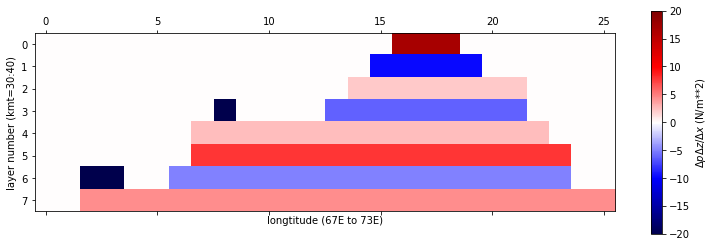

In [26]:
plt.matshow(p_dens[30:38,yy,1386:1412],cmap='seismic',vmin=-20,vmax=20)
plt.xlabel('longtitude (67E to 73E)')
plt.ylabel('layer number (kmt=30:40)')
plt.colorbar(label='$\Delta p\Delta z/\Delta x$ (N/m**2)')